In [1]:
import os.path as path
import raw_data_preprocessing as rdp
import warnings
import regressor as reg
import cluster as clu
import intervention_data_preprocessing as idp
import individual_differences_plot as plot
warnings.filterwarnings('ignore')

googledrive_loc = '/datasets/yis-google-drive'
data_folder_loc = 'Yi_UCI_research/GSR other works/2020 Summer_predict individual training/data/'
file_name = 'raw data/combined_3datasets.csv'
data_path = path.join(googledrive_loc, data_folder_loc, file_name)
raw_data = rdp.read_raw_data(data_path)
print('Used Feature columns: {}'.format(rdp.feature_col_names))
data_nomissing_training = rdp.delete_missing_row(raw_data)
# rdp.demographic_info(data_nomissing_training)
descpriptive_result = rdp.descriptive_info(data_nomissing_training)

Used Feature columns: ['MR_accpre', 'WM_Zpre', 'IC_Zreverse_pre', 'NT_Zpre', 'TCA_Zscore', 'CFQMALscore', 'Avg_grit_amb', 'NEOFFIExtraversion', 'NEOFFIAgreeableness', 'NEOFFIConscientiousness', 'NEOFFIEmotionalstability', 'NEOFFIIntellectorOpenness', 'VGQHoursCategorySumPastYear_Z', 'ParentalEducationSum', 'SelfReportedSESRatingSum', 'Physicalhealth', 'Physicalfitness', 'Psychohealth', 'Gamified', 'Difficulty', 'Bilingual']
The sample size of raw data is 949.
The sample size of no missing data (listwise) is 568.
Categorical Gamified information:Gamified
Gamified       315
Nongamified    253
dtype: int64
Categorical Difficulty information:Difficulty
Difficult     50
Middle       181
Moderate     169
hard         150
dtype: int64
Categorical Bilingual information:Bilingual
Bilingual      403
Monolingual    103
dtype: int64


In [2]:
# training data clean
int_test = idp.InterventionProcessor(data_nomissing_training)
int_test.basic_analyze()
int_test.mark_outlier_stewd(['std','mean'])
int_test.delete_outlier()

#using regressor to fit individual training data
piece_lin_reg = reg.PiecewiselinRegressor(['knot', 'slope1', 'slope2'])
log_lin_reg = reg.LogRegressor(['log_slope', 'log_bias'])
lin_reg = reg.LinearRegressor(['linear_slope', 'linear_bias'])

# ['knot','slope1','slope2','std','max','r2','turning_value']
# ['linear_slope', 'linear_bias']
int_test.register_regressor(piece_lin_reg)
int_test.fit()
# plot.plot_distribution(int_test.data, ['knot','slope1','slope2','std','max','r2'])

The mean of max is 5.157 with sd 5.815
The mean of std is 0.874 with sd 1.782
The mean of max is 5.157 with sd 5.815
The skew of std is 7.766
std:MC=0.193
interval of std is 2.6941854040225532 to -0.15348068866153236
     Unique  mean_1  mean_2  mean_3  mean_4  mean_5  mean_6  mean_7  mean_8  \
33       34   4.140   6.510   9.100   7.920   9.050   9.130   8.830  13.560   
41       42   4.150   7.010  18.550  29.390  38.250  43.580  49.000  51.500   
44       45   2.530   2.420   2.770   3.070   2.550   2.780   2.740   3.550   
147     148   2.510   3.010   3.520   3.960   5.700   7.230   8.600  10.450   
472     473   3.000   3.000   4.000   4.000   6.000   7.000   9.000  10.000   
505     506   4.000   7.000   9.000   8.000   9.000   9.000   9.000  14.000   
582     583   3.000   2.000   3.000   3.000   3.000   3.000   3.000   4.000   
583     584   4.000   7.000  19.000  29.000  38.000  44.000  49.000  52.000   
736     737   4.455  10.941  12.138   8.293  11.000   5.465   9.821  17.

The silhouette score of AgglomerativeClustering(n_clusters=3) is: 0.405
Sample of each cluster: label
0     81
1    164
2    261
dtype: int64


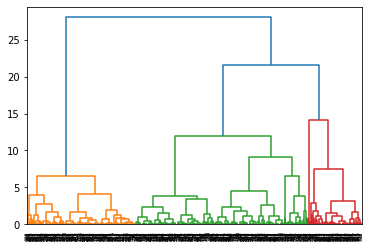

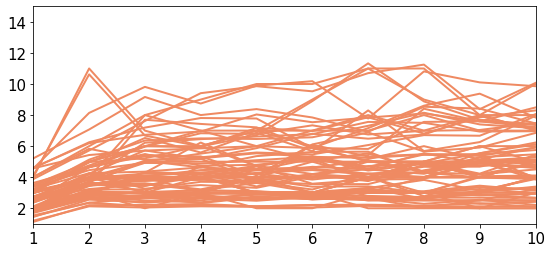

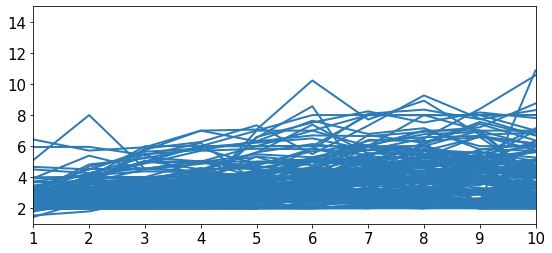

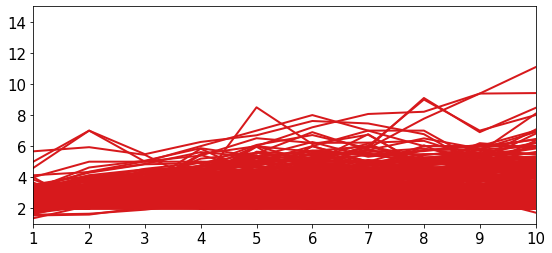

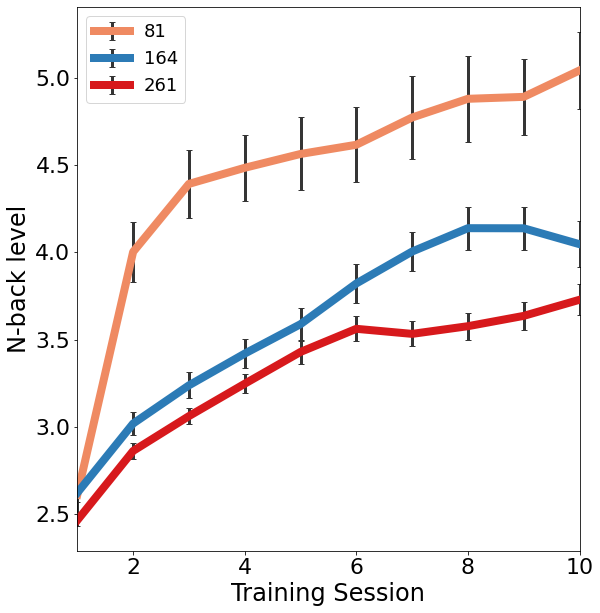

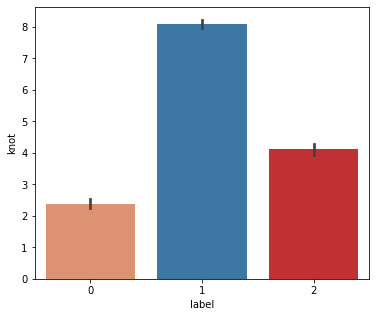

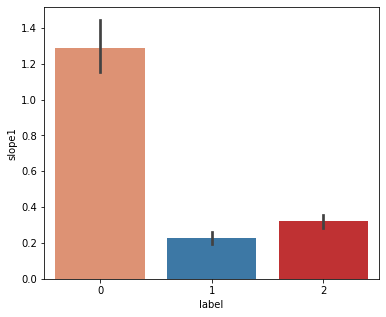

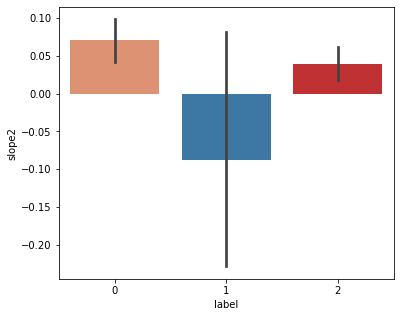

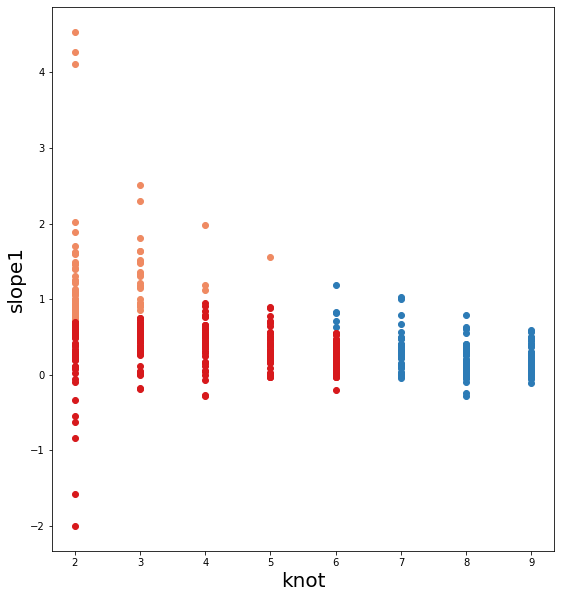

In [3]:
# clustering features
std_max = ['max','std']
pwlf = ['knot','slope1']
all_sess = ['mean_' + str(i) for i in range(1,11)]
# clustering methods
kmeans_3com = clu.Kmeans(2, pwlf)
hac_3com = clu.hierarchical(3, pwlf)
em_3com = clu.EM(2, pwlf)
# register clustering method
int_test.register_cluster_model(hac_3com)
int_test.cluster()
# plot
plot.plot_cluster_result(int_test.data, int_test.intervention_col_names, 'label')
plot.bar_plot_cluster(int_test.data, ['knot','slope1','slope2'])
plot.plot_scatter_cluster(int_test.data, pwlf)

These two features correlated above 0.5:Avg_grit_amb, NEOFFIConscientiousness
These two features correlated above 0.5:NEOFFIConscientiousness, Avg_grit_amb
These two features correlated above 0.5:Physicalhealth, Physicalfitness
These two features correlated above 0.5:Physicalfitness, Physicalhealth


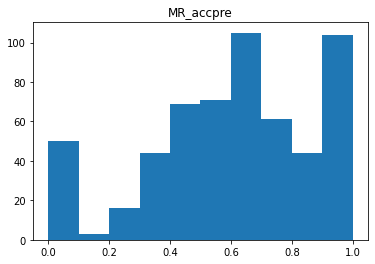

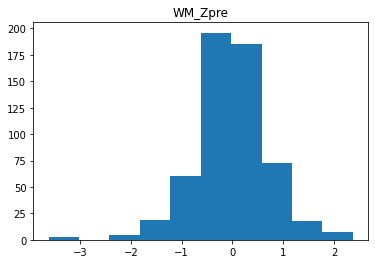

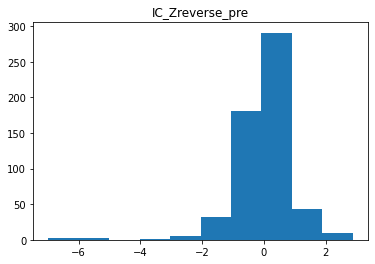

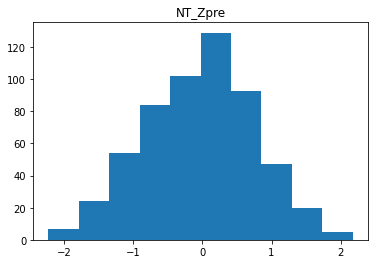

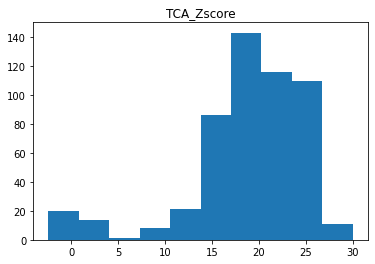

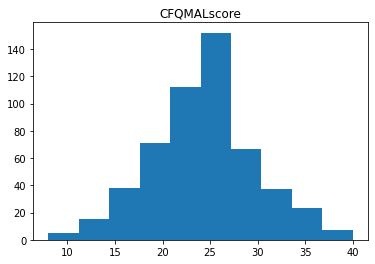

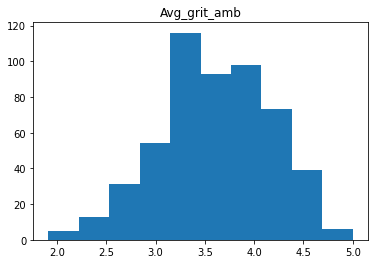

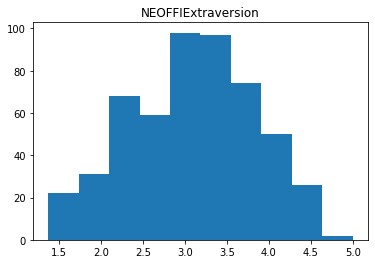

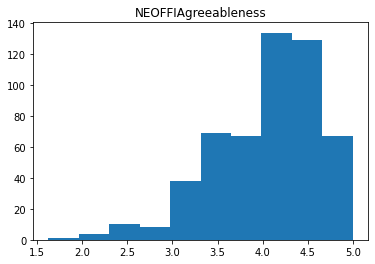

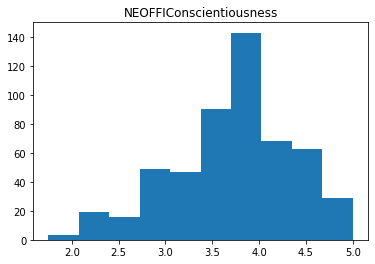

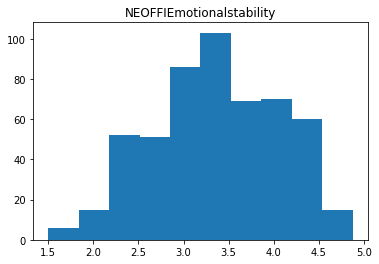

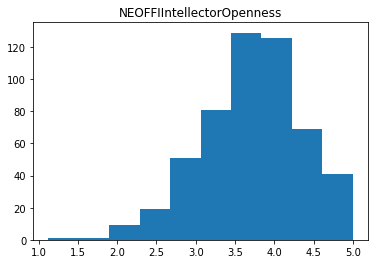

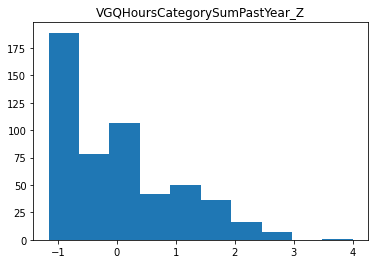

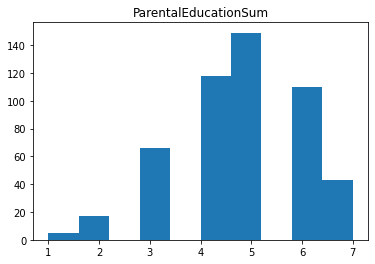

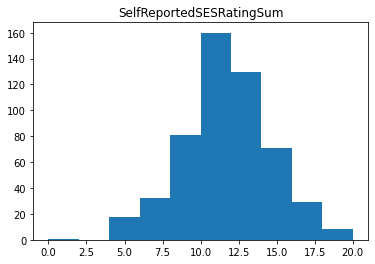

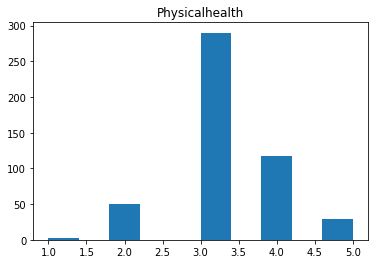

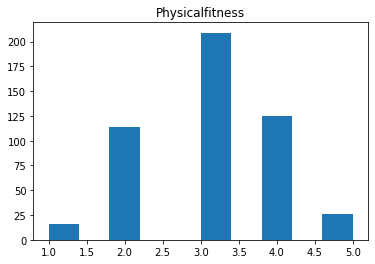

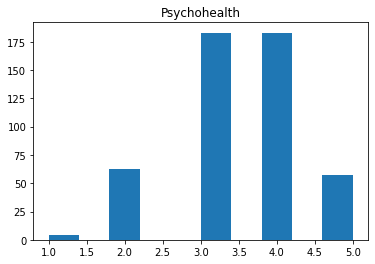

In [4]:
# Clean features
import feature_preprocessor as fp
fp_test = fp.FeatureProcessor(data_nomissing_training,add_demographic=False)
fp_test.corr_features()
fp_test.distri_features()
#fp_test.discretize_features()

The ANOVA test result for MR_accpre: f:2.118, p:0.121
The ANOVA test result for WM_Zpre: f:0.936, p:0.393
The ANOVA test result for IC_Zreverse_pre: f:0.098, p:0.907
The ANOVA test result for NT_Zpre: f:1.428, p:0.241
The ANOVA test result for TCA_Zscore: f:0.132, p:0.877
The ANOVA test result for CFQMALscore: f:0.393, p:0.675
The ANOVA test result for Avg_grit_amb: f:2.118, p:0.121
The ANOVA test result for NEOFFIExtraversion: f:0.273, p:0.761
The ANOVA test result for NEOFFIAgreeableness: f:0.173, p:0.841
The ANOVA test result for NEOFFIConscientiousness: f:0.460, p:0.632
The ANOVA test result for NEOFFIEmotionalstability: f:1.803, p:0.166
The ANOVA test result for NEOFFIIntellectorOpenness: f:3.719, p:0.025
The ANOVA test result for VGQHoursCategorySumPastYear_Z: f:5.272, p:0.005
The ANOVA test result for ParentalEducationSum: f:0.266, p:0.767
The ANOVA test result for SelfReportedSESRatingSum: f:0.108, p:0.898
The ANOVA test result for Physicalhealth: f:0.082, p:0.921
The ANOVA tes

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

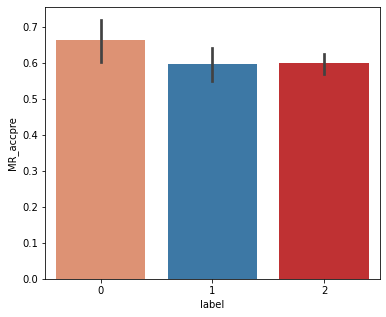

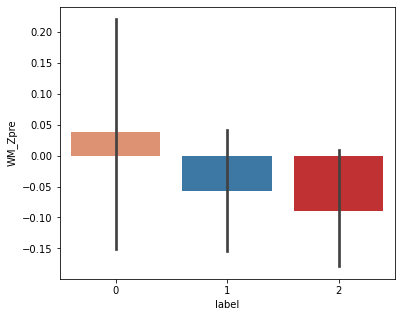

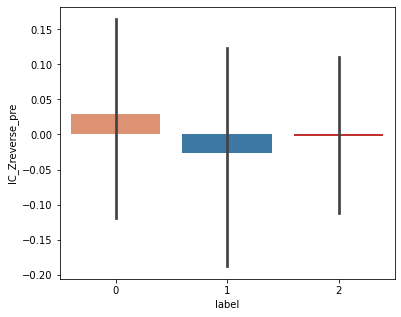

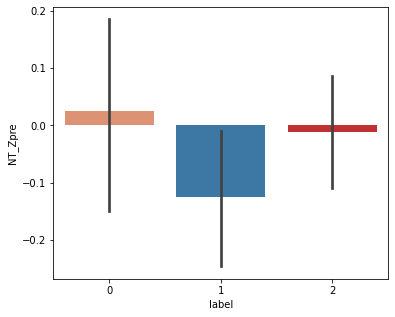

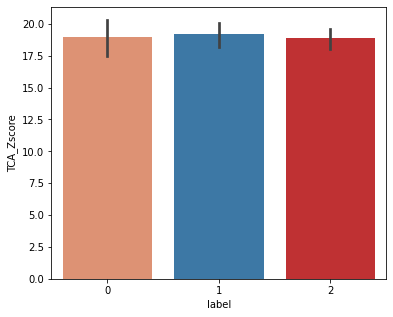

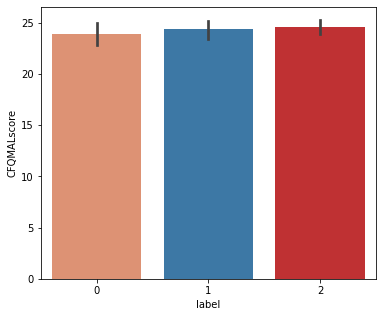

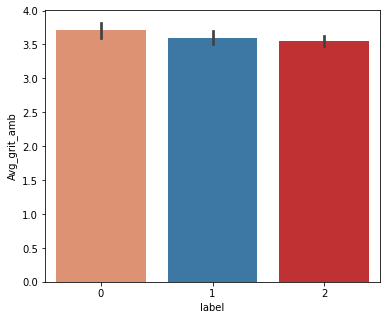

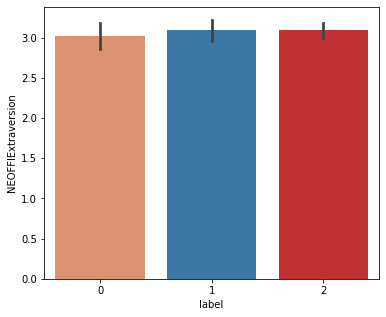

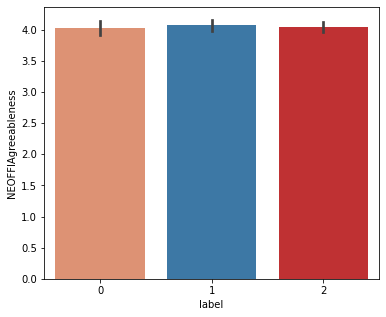

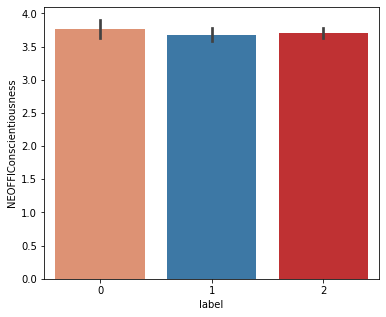

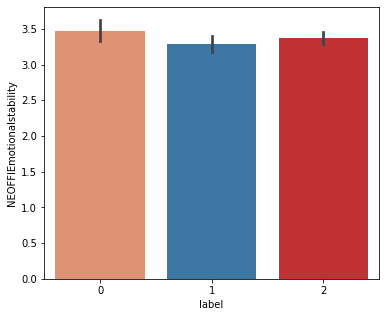

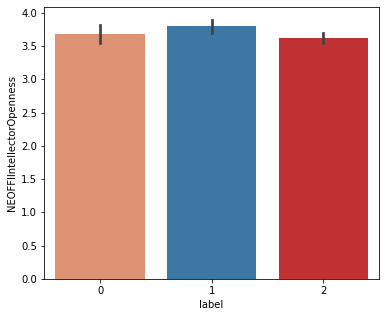

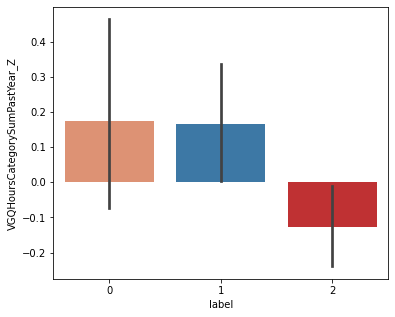

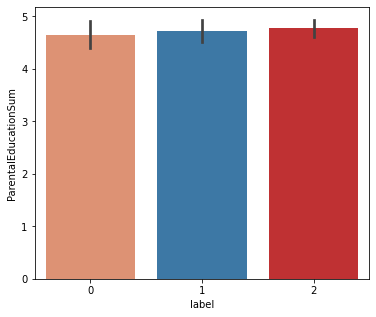

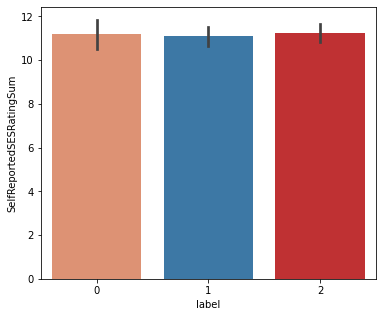

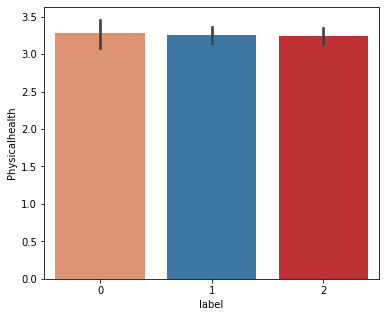

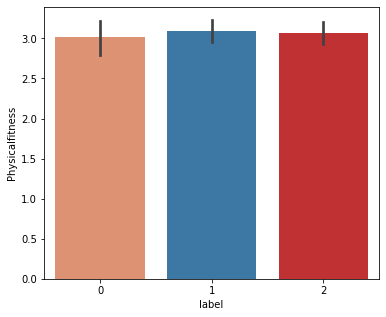

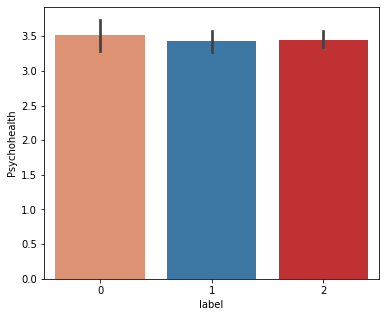

In [5]:
import classification_preprocessor as cp
cp_test = cp.ClassifyPreprocessor(int_test.data, fp_test.data)
# cp_test.features_impute_missing()
# cp_test.delete_missing()
# cp_test.delete_outlier() 
cp_test.feature_test()
cp_test.feature_selection(10)
# cp_test.use_categorical_features()

In [ ]:
#cp_test.data.to_csv(path.join(googledrive_loc, data_folder_loc, 'predictors_label_2022.csv'))

In [ ]:
X, Y, orig_len, feature_names = cp_test.resample_standardize({0:81, 1:164, 2:261}, oversample=False)
print('The input and output shape: {} and {}'.format(X.shape, Y.shape))
saved_data_path = path.join(googledrive_loc, data_folder_loc, 'saved data/2022/10features/')
# cp_test.save_data(X, Y, orig_len, feature_names, saved_data_path)

The sample weight before resample: Counter({2: 211, 1: 137, 0: 68})
The input and output shape: (416, 10) and (416,)


In [ ]:
# split a seperate testset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
cp_test.save_data(X_train, X_test, y_train, y_test, orig_len, feature_names, saved_data_path)

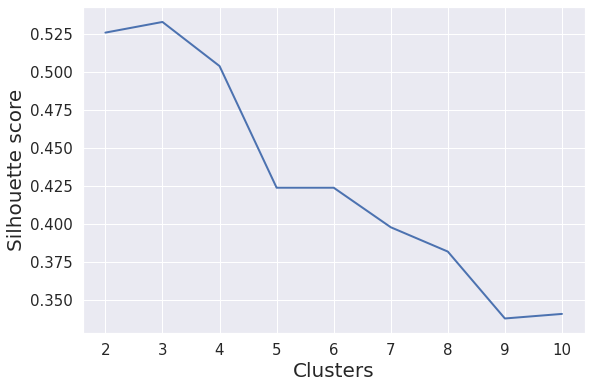

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [0.526, 0.533, 0.504, 0.424, 0.424, 0.398, 0.382, 0.338, 0.341]


fig, ax = plt.subplots(figsize=(9,6))
ax.tick_params(labelsize=15)
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Clusters', fontsize=20)
ax.set_ylabel('Silhouette score', fontsize=20)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c9e1ba2-0cb9-40ed-a01b-b56de82eb464' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>